# RF Signal Integrity to Power Integrity:  Part 10 Zout from Time-Domain

This folder contains the 1st simulation of the  
["part10"](https://www.microwavejournal.com/blogs/32-rf-signal-integrity-to-power-integrity) of a series blog/article  
[RF Signal Integrity to Power Integrity](https://www.microwavejournal.com/blogs/32-rf-signal-integrity-to-power-integrity) on  
[Microwave Journal](https://www.microwavejournal.com/).


# Install PyQSPICE First!

In your cmd.exe window.
```
> pip install PyQSPICE
```

## After Python Script

This folder contains resulting files after running the Python Script.
The [**"Sim1"**](https://github.com/Qorvo/QSPICE_on_MWJ/tree/main/Article10/Sim1) folder next to this-folder is "before running script".


## Overview Part 10, Sim #1

In Part-10, throughout [QSPICE](qspice.com) simulations, we confirm that the following equiation is valid where we can obtain an output impedance curve of frequency-domain based on a step-response transient / time-domain simulation.

$$
ℒ\left( \frac{d}{dt}\left( V_{OUT,Step-Response}(t) \right) \right) = - Z_{OUT}(s)
$$

In this Sim-1, we use a textbook Q = 10, RLC parallel resonant circuit.

## 1. Schematic and Netlists

We use below schmatic and generates 2 netlists for transient (time-domain) and AC (frequency-domain).

**NOTE:** A _gray box_ is a QSPICE's **"C++ => .DLL" block**.  You can find the code in this folder.  It sends out step-transient control signal to the voltage-control-current-source "G2" with a fine time-step control around the step event.

![](Q10.sch.png)

In [1]:
from PyQSPICE import clsQSPICE as pqs

import re
import subprocess
import math
import cmath

import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as pat
from matplotlib.transforms import ScaledTranslation as stran

import numpy as np
from numpy import sin, cos, pi, linspace

fname = "Q10"
run = pqs(fname)
run.qsch2cir()
run.cir4label('ac')
run.cir4label('tran')


## 2. AC Simulation: Reference Data

First, we run an AC simulation for our reference data.

From the Q(Tg) plot, we can confirm that this circuit shows Q = 10.

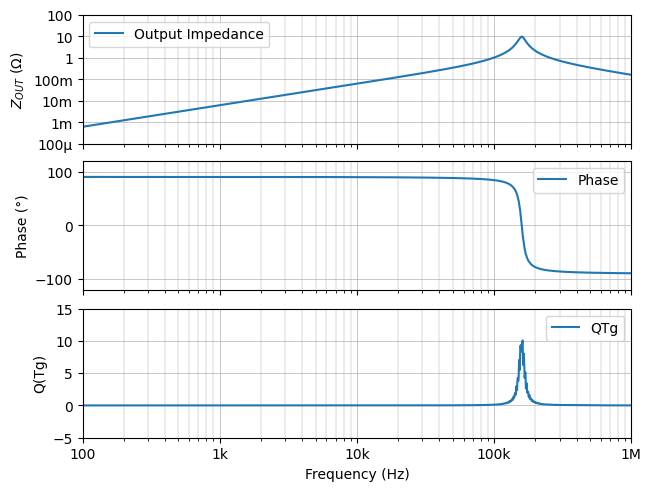

In [2]:
Ndata = 1024 * 2
run.selectSimLabel('ac', Nline = Ndata)

run.cir2qraw()

v = "V(out)"
i = "I(Iac)"

dfAC = run.LoadQRAW([v])

dfAC = run.GainPhase(dfAC, v, "abs(Zoac)", "arg(Zoac)")
run.comp2real(dfAC, ["Step", "abs(Zoac)", "arg(Zoac)", run.sim['Xlbl']])
#print(dfAC)

dfQ = pd.DataFrame()
dfQ = run.QTg(dfAC.loc[:,["Freq","arg(Zoac)"]], "fQTg", "QTg", 180/pi)
#print(dfQ)

plt.close('all')

fig, (axT, axM, axB) = plt.subplots(3, 1, sharex=True, constrained_layout=True)

dfAC.plot(ax=axT, x="Freq", y="abs(Zoac)", label="Output Impedance")
dfAC.plot(ax=axM, x="Freq", y="arg(Zoac)", label="Phase")
dfQ.plot(ax=axB, x="fQTg", y="QTg")
run.PrepFreqImpePlot(axT, "Frequency (Hz)", r"$Z_{OUT}$ ($\Omega$)", "auto", [-80,40], "")
run.PrepFreqGainPlot(axM, "Frequency (Hz)", r"Phase (°)", [100,1e6], [-120,120], "")
run.PrepFreqGainPlot(axB, "Frequency (Hz)", r"Q(Tg)", [100,1e6], [-5,15], "")

plt.savefig("Q10.ac.png", format='png', bbox_inches='tight')

plt.show()


## 3. Transient Simulation: Step-Load

Now, we run a transient simulation with the step current load.

This simulation generates total 10ms of data points, so we can have frequency information down to 100Hz.

As we have Q = 10, we can see heavy ringing.

### NOTEs
Many data points to simulate and process, for high precision results.  
Please check time-stamps for a rough idea how long does it take (depending on your PC speed)...  
At author's PC, 1min simulation and 1min data-loading.  
  
It generates **> 1GB data file**!


Simulation started at 2024-04-11 10:07:11.134843
Simulation finished at 2024-04-11 10:08:23.245064
Data Loading started at 2024-04-11 10:08:23.246070
Data Loading finished at 2024-04-11 10:09:09.542546
Data Plotting...


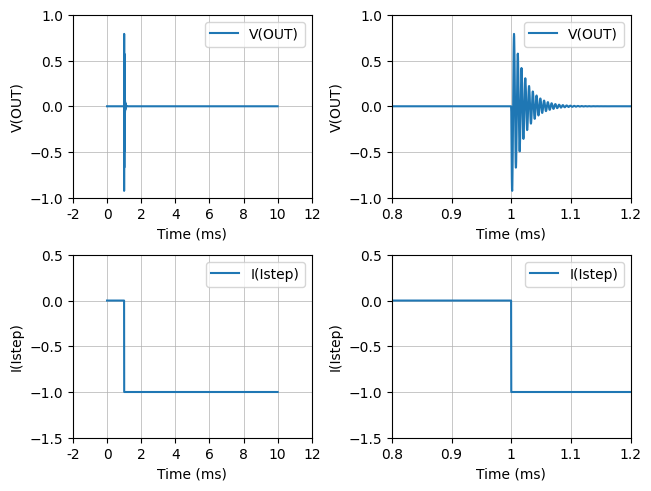

In [3]:
Ndata = 1024 * 32
run.selectSimLabel('tran', Nline = Ndata)

import datetime

print("Simulation started at " + str(datetime.datetime.now()))

run.cir2qraw()
#run.copy2qraw()  #use this line to re-use existing QRAW file

print("Simulation finished at " + str(datetime.datetime.now()))
print("Data Loading started at " + str(datetime.datetime.now()))

v = "V(out)"
i = "I(G2)"

dfTRAN = run.LoadQRAW([v,i])
#print(dfTRAN)

print("Data Loading finished at " + str(datetime.datetime.now()))
print("Data Plotting...")

plt.close('all')

fig, ax = plt.subplots(2, 2, constrained_layout=True)

for n in [0, 1]:
    dfTRAN.plot(ax=ax[0,n], x="Time", y=v, label="V(OUT)")
    dfTRAN.plot(ax=ax[1,n], x="Time", y=i, label="I(Istep)")

run.PrepTimePlot(ax[0,0], "Time", r"V(OUT)", "auto", [-1,1], "")
run.PrepTimePlot(ax[1,0], "Time", r"I(Istep)", "auto", [-1.5,0.5], "")
run.PrepTimePlot(ax[0,1], "Time", r"V(OUT)",   [0.8e-3,1.2e-3], [-1,1], "")
run.PrepTimePlot(ax[1,1], "Time", r"I(Istep)", [0.8e-3,1.2e-3], [-1.5,0.5], "")

plt.savefig("Q10.tran.png", format='png', bbox_inches='tight')

plt.show()


## 4. Data Processing:  L( d/dt(unit-response) )

Finally, we run FFT and Laplace transform, so to obtain / reconstruct our output impedance curve.

We can see good matching between our output impedance reconstruction method from time-domain and straight AC simulation.

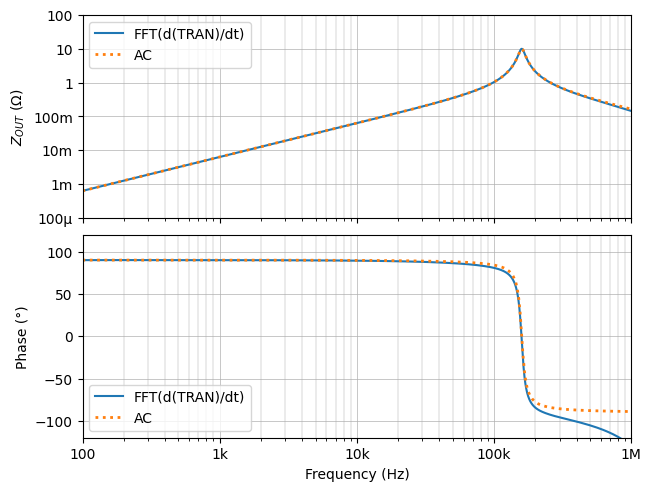

In [4]:
dfVo = dfTRAN[v].diff().iloc[1:]
dfIo = dfTRAN[i].diff().iloc[1:]
step = dfTRAN.iloc[1,0]

ftVo = (np.fft.fft(dfVo))[0:int(Ndata/2)]
ftIo = (np.fft.fft(dfIo))[0:int(Ndata/2)]
freq = (np.fft.fftfreq(Ndata,d=step))[0:int(Ndata/2)]

absZ = 20*np.log10(np.abs(ftVo / ftIo))
angZ = np.angle(ftVo / ftIo) / np.pi * 180

plt.close('all')

fig, (axT, axB) = plt.subplots(2, 1, sharex=True, constrained_layout=True)

axT.plot(freq, absZ, label="FFT(d(TRAN)/dt)")
axB.plot(freq, angZ, label="FFT(d(TRAN)/dt)")
axT.legend()
axB.legend()

dfAC.plot(ax=axT, x="Freq", y="abs(Zoac)", label="AC", linestyle="dotted", linewidth=2)
dfAC.plot(ax=axB, x="Freq", y="arg(Zoac)", label="AC", linestyle="dotted", linewidth=2)

run.PrepFreqImpePlot(axT, "Frequency (Hz)", r"$Z_{OUT}$ ($\Omega$)", "auto", [-80,40], "")
run.PrepFreqGainPlot(axB, "Frequency (Hz)", r"Phase (°)", [100,1e6], [-120,120], "")

plt.savefig("Q10.Lddt.png", format='png', bbox_inches='tight')

plt.show()


## 5. Cleaning

Removing 1GB data file.

In [5]:
run.clean(['tran.qraw'])